In [ ]:
'''
Week10 Project: Movie Recommender System - Unsupervised Learning Models
Goal: 

The program should run the following steps:
1. Read the data
2. EDA 
3. Train CF model 
4. Train PCA model - optional
5. Train NMF model - optional
6. Write flask web interface
7. Store movie lens data in Postgres
8. Create a JSON API
'''

In [125]:
## packages
import pandas as pd
import time 
import datetime 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF

In [101]:
## Get Data + Cleaning

#movie_lens = pd.read_csv()
links = pd.read_csv('data/links.csv')
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')

#Merge the dataframes 
df1 = links.merge(movies, how='left', on='movieId')
df2 = ratings.merge(df1, how='left', on='movieId')
movie_lens = df2.rename(columns={'timestamp': 'rating_timestamp'})
tag_data = movie_lens.merge(tags, how='left', on=['userId','movieId'])
tag_data = tag_data.rename(columns={'timestamp':'tag_timestamp'})

#Deal with missing values 
movie_lens.isna().sum()
tag_data['tag'] = tag_data['tag'].fillna('none')
tag_data['tag_timestamp'] = tag_data['tag_timestamp'].fillna('0')

#Change Id variables to string type variable
movie_lens['userId'] = movie_lens['userId'].astype(str)
movie_lens['movieId'] = movie_lens['movieId'].astype(str)
movie_lens['imdbId'] = movie_lens['imdbId'].astype(str)
movie_lens['tmdbId'] = movie_lens['tmdbId'].astype(str)

#Change tag timestamp into integer
tag_data['tag_timestamp'] = tag_data['tag_timestamp'].astype(int)

movie_lens.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   userId            100836 non-null  object 
 1   movieId           100836 non-null  object 
 2   rating            100836 non-null  float64
 3   rating_timestamp  100836 non-null  int64  
 4   imdbId            100836 non-null  object 
 5   tmdbId            100836 non-null  object 
 6   title             100836 non-null  object 
 7   genres            100836 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 6.9+ MB


In [102]:
movie_lens.duplicated().sum()

0

In [103]:
#Change UTC string time to local time 

def utc_to_timestamp_conversion(df,var):
    y = []
    length = len(df[var])
    for i in range(length):
        x = df[var][i]
        ts = datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')
        y.append(ts)
    
    df[var] = y

utc_to_timestamp_conversion(movie_lens,'rating_timestamp')
utc_to_timestamp_conversion(tag_data, 'tag_timestamp')

movie_lens.head() 

,userId,movieId,rating,rating_timestamp,imdbId,tmdbId,title,genres
0,1,1,4.0,2000-07-30 20:45:03,114709,862.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,2000-07-30 20:20:47,113228,15602.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,2000-07-30 20:37:04,113277,949.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,2000-07-30 21:03:35,114369,807.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,2000-07-30 20:48:51,114814,629.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [104]:
###EDA 
# plot a histogram of the movie ratings. Are they distributed evenly?
movie_lens.describe()

,rating
count,100836.000000
mean,3.501557
std,1.042529
min,0.500000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


<AxesSubplot:xlabel='rating', ylabel='Count'>

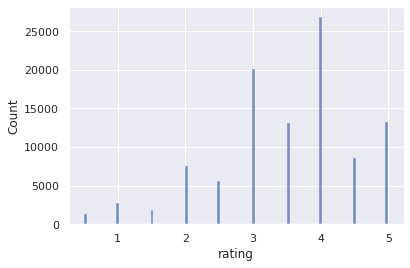

In [89]:
sns.histplot(data=movie_lens, x='rating')

In [44]:
#plot a histogram of the ratings for a few genres.
gen = movie_lens.groupby(by='genres').describe().sample(10)
gen.head()

rating                      \
                                                 count      mean       std   
genres                                                                       
Action|Drama|Thriller|IMAX                         8.0  2.687500  1.131923   
Animation|Drama                                   20.0  3.925000  0.935766   
Comedy|Crime|Drama|Mystery|Romance                10.0  3.750000  0.634648   
Action|Adventure|Comedy|Drama|War                 46.0  3.706522  0.764316   
Action|Adventure|Animation|Drama|Fantasy|Sci-Fi    1.0  3.500000       NaN   

                                                                               
                                                 min    25%   50%    75%  max  
genres                                                                         
Action|Drama|Thriller|IMAX                       1.0  1.875  2.75  3.625  4.0  
Animation|Drama                                  1.0  3.500  4.00  4.500  5.0  
Comedy|Crime|Drama|Mystery|Romance               2.5  3.500  4.00  4.000  4.5  
Action|Adventure|Comedy|Drama|War                1.0  3.000  4.00  4.000  5.0  
Action|Adventure|Animation|Drama|Fantasy|Sci-Fi  3.5  3.500  3.50  3.500  3.5

In [25]:
movie_lens['genres'].unique()

array(['Adventure|Animation|Children|Comedy|Fantasy', 'Comedy|Romance',
       'Action|Crime|Thriller', 'Mystery|Thriller',
       'Crime|Mystery|Thriller', 'Action|Comedy|Horror|Thriller',
       'Adventure|Comedy|Crime|Romance', 'Action|Drama|War',
       'Action|Drama|Romance|War', 'Comedy|War', 'Action|Romance|Western',
       'Comedy', 'Adventure|Comedy', 'Comedy|Drama',
       'Action|Adventure|Sci-Fi', 'Comedy|Crime|Drama|Thriller',
       'Action|Crime|Drama|Thriller', 'Comedy|Drama|Romance|War',
       'Adventure|Children|Romance', 'Action|Comedy|Crime|Fantasy',
       'Action|Thriller', 'Thriller', 'Action|Adventure|Sci-Fi|Thriller',
       'Drama|War', 'Comedy|Romance|Thriller',
       'Action|Adventure|Comedy|Romance', 'Action|Drama|Western',
       'Adventure|Drama|Western', 'Crime|Horror|Thriller',
       'Animation|Children|Fantasy|Musical',
       'Action|Adventure|Mystery|Thriller',
       'Adventure|Animation|Children|Fantasy|Musical',
       'Adventure|Animation|Chil

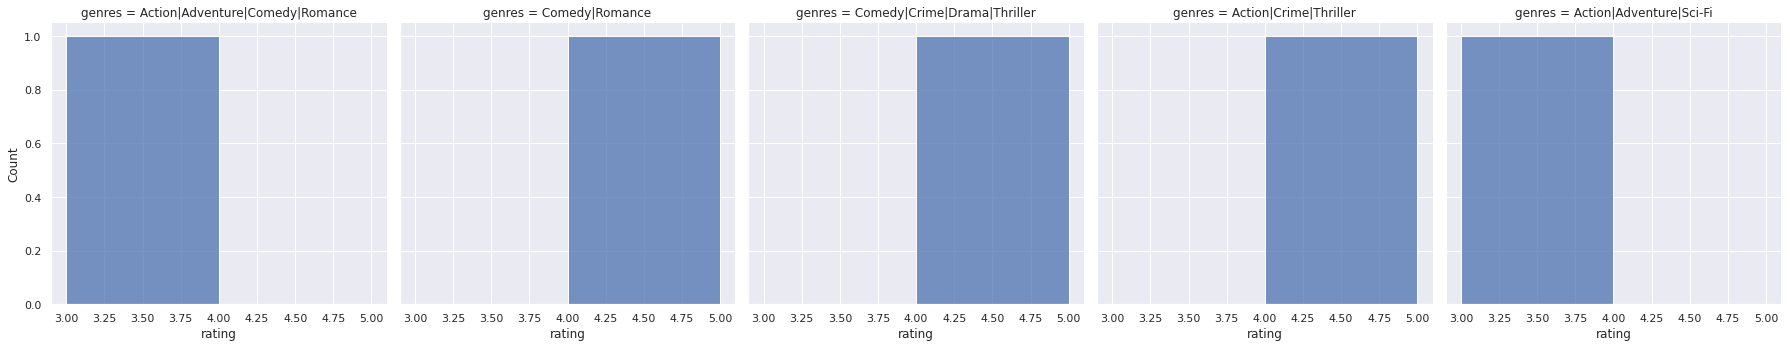

In [9]:
sns.set_theme(style="darkgrid")

sns.displot(
    movie_lens, x='rating', col=movie_lens['genres'].sample(5), col_wrap=5,
    binwidth=1, height= 5, facet_kws=dict(margin_titles=True))


<AxesSubplot:xlabel='rating', ylabel='Count'>

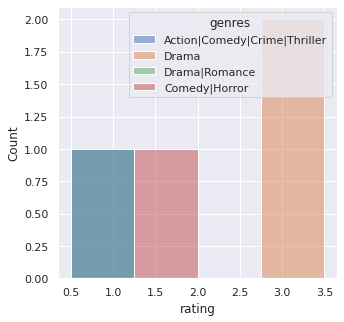

In [94]:
plt.figure(figsize=(5,5))

sns.histplot(data=movie_lens, x='rating', hue=movie_lens['genres'].sample(5))

In [90]:
meancount = movie_lens.groupby('movieId')['rating'].agg(['mean','count', 'min', 'max'])
meancount.head(3)

,mean,count,min,max
movieId,,,,
1,3.920930,215,0.5,5.0
10,3.496212,132,0.5,5.0
100,2.785714,14,1.0,4.0


In [91]:
mc = meancount.sort_values(by=['mean','count'], ascending=[False, False]).head(5)
mc.head()

,mean,count,min,max
movieId,,,,
1151,5.0,2,5.0,5.0
3473,5.0,2,5.0,5.0
53,5.0,2,5.0,5.0
6442,5.0,2,5.0,5.0
6818,5.0,2,5.0,5.0


In [97]:
# apply the weighted ranking equation from the notebook. 
# What values for m give (subjectively) good results in your opinion?

#We are using a ranking algorithm to combine mean and count into a single number
# R - average rating of a movie
# v - number of votes for one movie
# C - average rating of all movies
# m - threshold hyperparameter(set this manually)

def weighted_rank(R,v,C,m):
    return R * v/(v+m) + C* m/(v+m)

C = movie_lens['rating'].mean()
m = 100 #experiment with this

v = mc['count']
R = mc['mean']
m = 1000000.0

ranking = R * v/(v+m)+C *m/(v+m)
ranking.head()

movieId
1151    3.50156
3473    3.50156
53      3.50156
6442    3.50156
6818    3.50156
dtype: float64

In [117]:
# Find the most similar user from the classroom data first, then try the same on MovieLens

multi = movie_lens[['userId', 'movieId','rating']]
multi.duplicated().sum()
multi.head(2)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0


In [121]:
matrix = multi.pivot(index='movieId', columns='userId', values='rating').fillna(0)
matrix.head(5)

userId,1,10,100,101,102,103,104,105,106,107,...,90,91,92,93,94,95,96,97,98,99
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,...,3.0,4.0,0.0,3.0,0.0,0.0,5.0,0.0,4.5,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,3.5,0.0,4.0,3.0,0.0,0.0,0.0,0.0,4.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='userId', ylabel='movieId'>

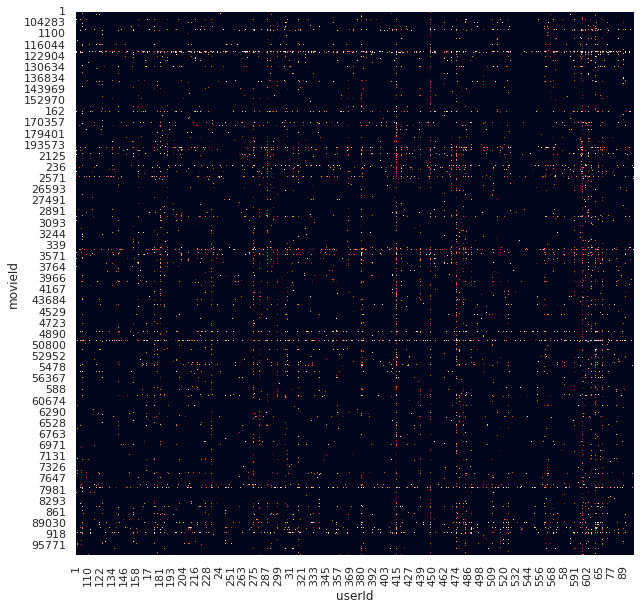

In [124]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, cbar=None)

In [127]:
# Calculate similarities for 2 users 

user_1 = pd.DataFrame(matrix['1'])
user_2 = pd.DataFrame(matrix['5'])
cosine_similarity(user_1, user_2) 

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Calculate all similarities and sort them by highest similarity and rating 

#u1 = "Hakan"
#go through all users u2 (!= u1):
#    calculate the similarity between u1 and u2 -> sim
#    (0.0 dissimilar, 1.0 identical)
#    find the user with the highest similarity -> u_best

#sort the movies rated by u_best by rating
#recommend a few of them






In [ ]:
#For Tomorrow Class
# take whatever recommender you have (a random one is also fine) and put it in a Python function. 
# take the Python function and put it in a module (a .py file). This will also be useful tomorrow.

def recommender (df,var):
    names = df[var].unique()
    random.choice(names)
    

In [ ]:
### Train Neigborhood based Collaborative Filtering (unsupervised learning model) # Needs similarities 
### Calculate similarities 

In [ ]:
### Train Non-negative Matrix Factoriation model (unsupervised learning model) #uses statistical model 

# movie, ratings by users
data = [
    [5, 4, 1, 1, 3],
    [3, 2, 1, 3, 1],
    [3, 3, 3, 3, 5],
    [1, 1, 5, 4, 4],
]
columns = ['Titanic', 'Tiffany', 'Terminator', 'Star Trek', 'Star Wars'] #movies
index = ['Ada', 'Bob', 'Steve', 'Margaret'] #users

#need a dataframe for this
R = pd.DataFrame(data, index=index, columns=columns).values

#create a model and set the hyperparameters
# model assumes R ~ PQ'
model = NMF(n_components=2, init='random', random_state=10)

model.fit(R)

Q = model.components_  # movie-genre matrix

P = model.transform(R)  # user-genre matrix

print(model.reconstruction_err_) #reconstruction error

nR = np.dot(P, Q)
print(nR) ## The reconstructed matrix!

# predict the hidden features for a new data point
query = [[1, 2, 5, 4, 5]]
#in this case, a new user providing ratings for the 5 movies.
print(model.transform(query))

In [ ]:
### PCA Analysis/Hierarchical clustering on Topic Modeling(unsupervised learning model)
### Bin variables: genres, tags  ## should we?